In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import numpy as np
import itertools
from scipy.stats import norm
import time
import sys
sys.path.append("..")
from smfs import cossio
import kinetics

In [3]:
def pmf2d(xq, qk):
    fig, ax = plt.subplots(figsize=(6,5))
    counts, ybins, xbins, image = ax.hist2d(xk, qk, \
            bins=[np.linspace(-12,12,100), np.linspace(-12,12,100)])
    pmf = -np.log(counts.transpose())
    pmf -= np.min(pmf)
    cs = ax.contourf(pmf, \
            extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
            cmap=cm.rainbow, levels=np.arange(0,10 ,1))
    cbar = plt.colorbar(cs)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$q$', fontsize=20)
    plt.tight_layout()

In [4]:
def calc_rates(y):
    lifeA, lifeB = kinetics.calc_life([y])
    meanA = 1./np.exp(np.mean(np.log([x for x in lifeA if x>0])))
    meanB = 1./np.exp(np.mean(np.log([x for x in lifeB if x>0])))
    errorA = meanA/np.sqrt(len(lifeA))
    errorB = meanA/np.sqrt(len(lifeB))
    return np.mean([meanA, meanB]), np.mean([errorA, errorB])

In [5]:
# Globals
dt = 5e-4
Dx = 1. # Diffusion coefficient for molecular coordinate

### Molecular potential of mean force 

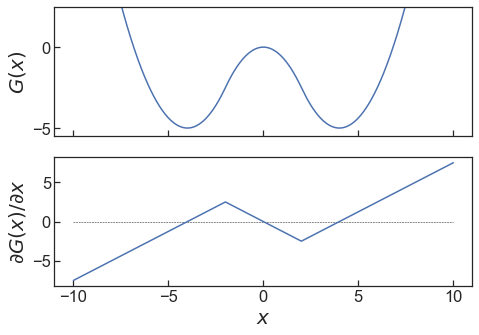

In [6]:
x = np.linspace(-10,10,1000)
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)
Gx = [cossio.Gx(y, barrier=5.) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=5.) for y in x]
ax[0].plot(x, Gx)
ax[0].set_ylabel('$G(x)$', fontsize=20)
ax[0].set_ylim(-1.1*5,0.5*5)

ax[1].plot(x, dGqxdx)
ax[1].set_xlabel('$x$', fontsize=20)
ax[1].set_ylabel('$\partial G(x)/\partial x$', fontsize=20)
ax[1].hlines(0, -10, 10, linestyle='dashed', linewidth=0.5)

#ax[2].set_ylabel('$\partial^2 G(x)/\partial x^2$', fontsize=20)

plt.tight_layout()

### Diffusion on molecular coordinate

In [ ]:
start = time.time()
x, q = [5., 0.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=0., \
                             Dx=Dx, numsteps=int(1e9), fwrite=int(0.1/dt))
end = time.time()
print (end - start)

In [43]:
data = np.column_stack((t,xk,qk))

h5file = "data/cossio_kl%g_Dx%g_Dq%g_dt%g.h5"%(0,Dx, 0, dt)
with h5py.File(h5file, "w") as hf:
    hf.create_dataset("data", data=data)

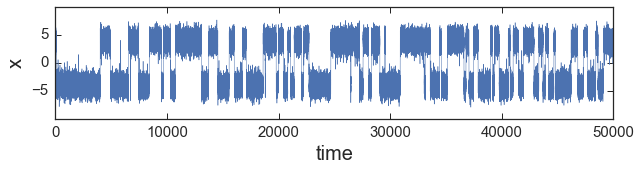

In [8]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(t, xk, linewidth=0.5)
ax.set_ylim(-10,10)
ax.set_xlim(0,50000)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

In [9]:
rate0 = np.array(calc_rates(xk))
print 1./rate0[0]

4977.60688488


In [11]:
lifeA, lifeB = kinetics.calc_life([xk])

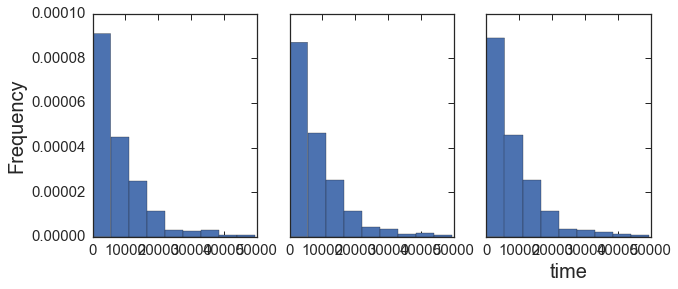

In [12]:
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True, sharex=True)
lifetimes = lifeA+lifeB
ax[0].hist(lifeA, bins=np.linspace(0,np.max(lifetimes),10),normed=True)
ax[1].hist(lifeB, bins=np.linspace(0,np.max(lifetimes),10),normed=True)
ax[2].hist(lifetimes, bins=np.linspace(0,np.max(lifetimes),10),normed=True)
ax[2].set_xlabel('time', fontsize=20)
ax[0].set_ylabel('Frequency', fontsize=20)

(0, 8209.7899414062613)


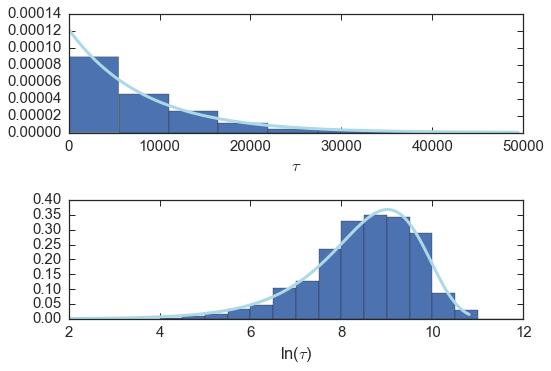

In [15]:
from scipy.stats import expon
from scipy.stats import norm
fig, ax = plt.subplots(2,1)
histogram, bin_edges, patches = \
        ax[0].hist(lifetimes, \
                   bins=np.linspace(0,np.max(lifetimes),10), normed=True, cumulative=False)
ax[0].set_xlabel(r'$\tau$')

param = expon.fit(lifetimes, floc=0)
print param
x = np.linspace(0,np.max(lifetimes),200)
ax[0].plot(x, expon.pdf(x, loc=param[0], scale=param[1]), color='lightblue', lw=3)
#ax[0].set_yticks([0, 0.0004, 0.0008])

histogram, bin_edges, patches = \
        ax[1].hist([np.log(x) for x in lifetimes if x > 0], \
                   bins=np.linspace(0,12,25), normed=True)
ax[1].set_xlabel(r'ln($\tau$)')
lx = np.linspace(0,np.log(np.max(lifetimes)),2000)
pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
ax[1].plot(lx, pdf, color='lightblue', lw=3)
ax[1].set_xlim(2,12)
#ax[1].set_ylim(0,0.4)
#ax[1].set_yticks([0,0.2,0.4])
plt.tight_layout()

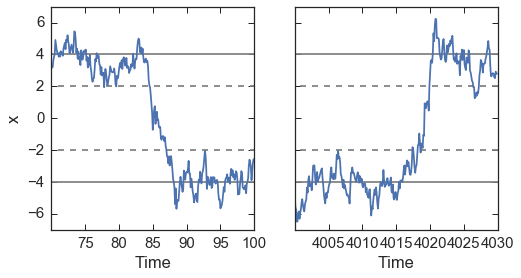

In [40]:
fig, ax = plt.subplots(1,2, figsize=(8,4),sharey=True)
ax[0].hlines(y=4,xmin=0,xmax=max(t), color='gray')
ax[0].hlines(y=-4,xmin=0,xmax=max(t), color='gray')
ax[0].hlines(y=2,xmin=0,xmax=max(t), linestyles='dashed', color='gray')
ax[0].hlines(y=-2,xmin=0,xmax=max(t), linestyles='dashed', color='gray')

ax[0].plot(t[700:1000], xk[700:1000])
ax[0].set_xlim(t[700],t[1000])
ax[0].set_ylim(-7,7)

ax[1].hlines(y=4,xmin=0,xmax=max(t), color='gray')
ax[1].hlines(y=-4,xmin=0,xmax=max(t), color='gray')
ax[1].hlines(y=2,xmin=0,xmax=max(t), linestyles='dashed', color='gray')
ax[1].hlines(y=-2,xmin=0,xmax=max(t), linestyles='dashed', color='gray')

ax[1].plot(t[40000:40300], xk[40000:40300])
ax[1].set_xlim(t[40000],t[40300])
ax[0].set_ylabel('x')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')


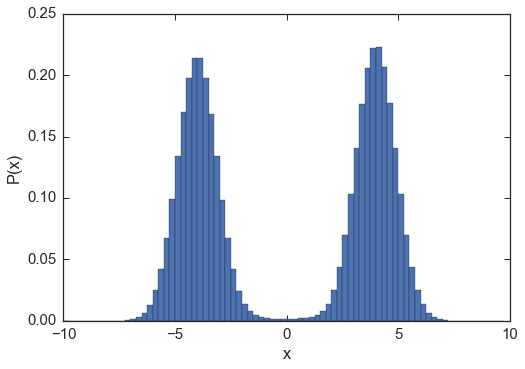

In [48]:
fig, ax = plt.subplots()
hist, bin_edges, patches = \
        ax.hist(xk, bins=np.arange(-10,10,0.25), normed=True)
ax.set_ylabel('P(x)')
ax.set_xlabel('x')

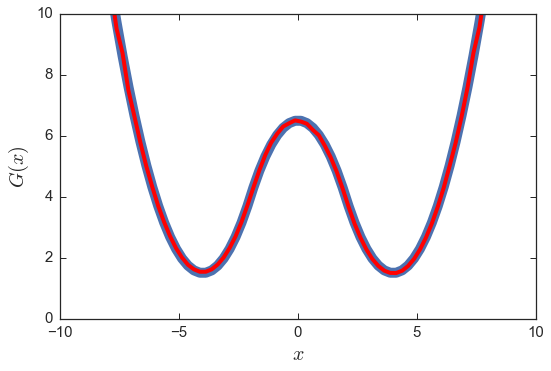

In [49]:
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
fig, ax = plt.subplots()
ax.plot(bin_centers, [cossio.Gx(x) + 6.5   for x in bin_centers], lw=10)
ax.plot(bin_centers, -np.log(hist), 'red', lw=4)
ax.set_ylabel('$G(x)$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylim(0,10)
plt.tight_layout()

In [60]:
data = np.array(zip(t,xk))
tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
    kinetics.lifetimes(data, f_bound=-2, u_bound=2)

In [65]:
tpt_u = []
tpt_f = []
for td in tp_u:
    tpt_u.append(td[:,0][-1] - td[:,0][0])
for td in tp_f:
    tpt_f.append(td[:,0][-1] - td[:,0][0])

(1.6, 1.1286132812500003)
(1.6, 1.1226562499999999)


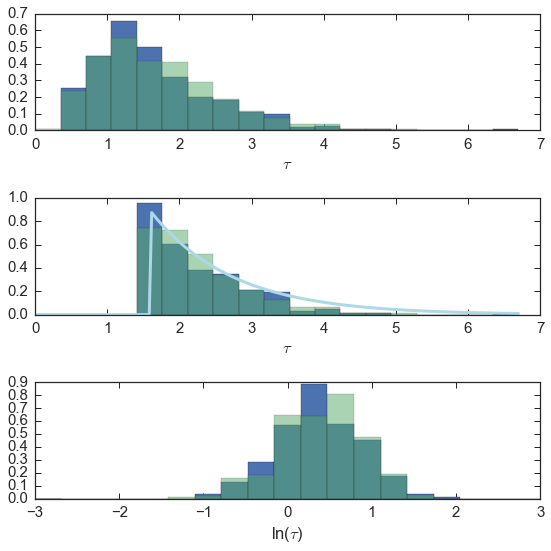

In [104]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
histogram, bin_edges, patches = \
        ax[0].hist(tpt_f, \
                   bins=np.linspace(0,np.max(tpt_f),20), \
                   normed=True, cumulative=False)
histogram, bin_edges, patches = \
        ax[0].hist(tpt_u, \
                   bins=np.linspace(0,np.max(tpt_f),20), \
                   normed=True, cumulative=False, alpha=0.5)

histogram, bin_edges, patches = \
        ax[1].hist([x for x in tpt_f if x>1.5], \
                   bins=np.linspace(0,np.max(tpt_f),20), \
                   normed=True, cumulative=False)
param = expon.fit([x for x in tpt_f if x > 2] , floc=1.6)
print param
x = np.linspace(0,np.max(tpt_f),200)
ax[1].plot(x, expon.pdf(x, loc=param[0], scale=param[1]), color='lightblue', lw=3)
histogram, bin_edges, patches = \
        ax[1].hist([x for x in tpt_u if x>1.5], \
                   bins=np.linspace(0,np.max(tpt_f),20), \
                   normed=True, cumulative=False, alpha=0.5)
param = expon.fit([x for x in tpt_u if x > 2] , floc=1.6)
print param
ax[1].plot(x, expon.pdf(x, loc=param[0], scale=param[1]), color='lightgreen', lw=3)

#ax[0].set_yticks([0, 0.0004, 0.0008])

histogram, bin_edges, patches = \
        ax[2].hist(np.log(tpt_f), \
                   bins=np.linspace(-3,3,20), normed=True)
histogram, bin_edges, patches = \
        ax[2].hist(np.log(tpt_u), \
                   bins=np.linspace(-3,3,20), normed=True, alpha=0.5)
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')
ax[2].set_xlabel(r'ln($\tau$)')
#lx = np.linspace(0,np.log(np.max(lifetimes)),2000)
#pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
#ax[1].plot(lx, pdf, color='lightblue', lw=3)
#x[1].set_xlim(2,12)
#ax[1].set_ylim(0,0.4)
#ax[1].set_yticks([0,0.2,0.4])
plt.tight_layout()

### Diffusion on measuring coordinate

In [105]:
kl = 0.3
x, q = [5., 5.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                        Dx=0, Dq=Dx, numsteps=int(1e6), fwrite=int(1./dt))

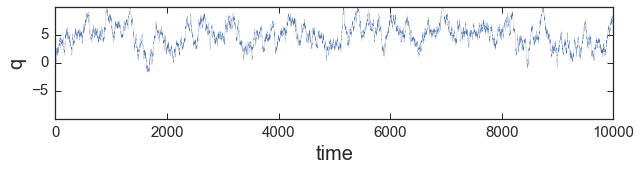

In [106]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(qk, linewidth=0.2)
#ax.plot(qk[0:-1:100], linewidth=0.1)
ax.set_ylim(-10,10)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('q', fontsize=20)

### Diffusion in two dimensions

In [107]:
x = np.linspace(-10,10,100)
G2d = np.ones((50, 100), float)*[cossio.Gx(y, barrier=5.) for y in x]
q = np.linspace(-12,12,50)
for i, j in itertools.product(range(50), range(100)):
    G2d[i,j] += cossio.V(q[i], x[j], kl)
G2d = np.array(G2d)
G2d -= np.min(G2d)

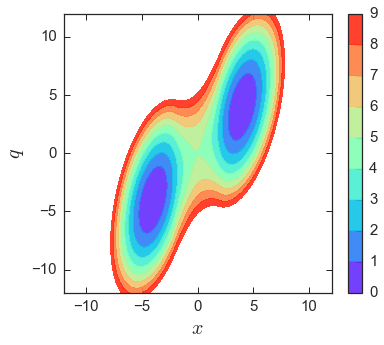

In [125]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(x, q,  G2d, cmap=cm.rainbow, levels=np.arange(0,10,1), alpha=0.9)
cbar = plt.colorbar(cs)
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$q$', fontsize=20)

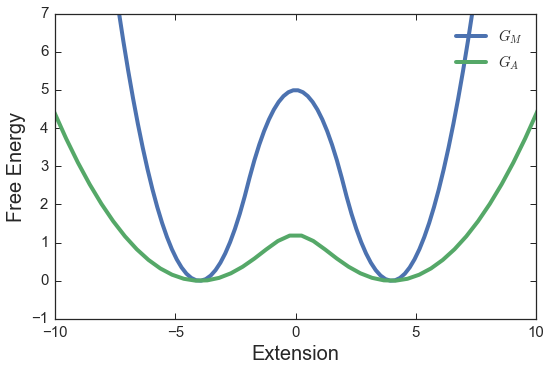

In [126]:
expGM = np.trapz(np.exp(-G2d), q, axis=0)
GM = -np.log(expGM)
expGA = np.trapz(np.exp(-G2d), x, axis=1)
GA = -np.log(expGA)
fig, ax = plt.subplots()
ax.plot(x, GM - np.min(GM), label='$G_M$', lw=4)
ax.plot(q, GA  - np.min(GA), label='$G_A$', lw=4)
#ax.plot(bin_centers, [cossio.Gx(y) for y in bin_centers], '--', c='red', lw=3)
ax.set_xlim(-10,10)
ax.set_ylim(-1,7)
ax.set_xlabel('Extension', fontsize=20)
ax.set_ylabel('Free Energy', fontsize=20)
ax.legend(loc=1)
fig.tight_layout()

In [130]:
x, q = [5., 5.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx, numsteps=int(1e8), fwrite=int(0.1/dt))

(-10, 10)

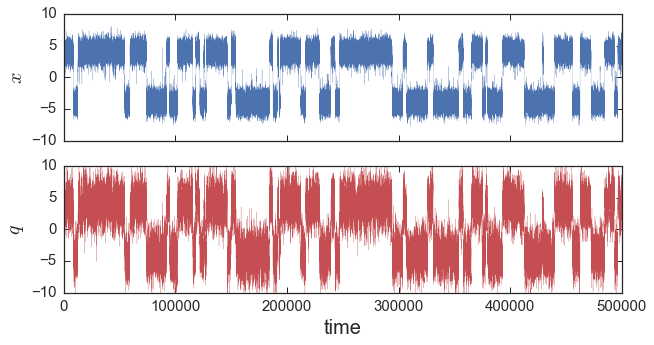

In [131]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].plot(xk, linewidth=0.2)
ax[1].plot(qk, 'r', linewidth=0.2)
ax[1].set_xlabel('time', fontsize=20)
ax[1].set_ylabel('$q$', fontsize=20)
ax[0].set_ylabel('$x$', fontsize=20)
ax[0].set_ylim(-10, 10)
#ax[0].set_xlim(0, numsteps)

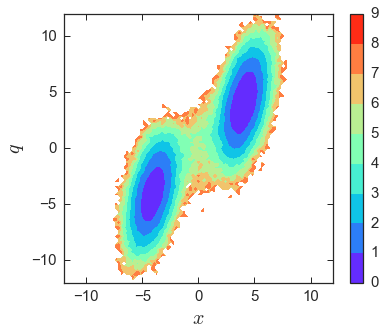

In [132]:
n

In [ ]:
scaling = [5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
nsteps = [1e7, 2e7, 2e7, 2e7, 2e7, 2e7, 2e7, 5e7, 5e7, 5e7]
trajs = {}
for i,sc in enumerate(scaling):
    trajs[sc] = {}
    x, q = [5., 5.]
    numsteps = int(nsteps[i])
    xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx*sc, numsteps=numsteps, fwrite=100)
    trajs[sc]['x'] = xk
    trajs[sc]['q'] = qk
    
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
    ax[0].plot(xk, linewidth=0.2, label='Dx/Dq=%g'%(1./sc))
    ax[1].plot(qk, 'r', linewidth=0.2)
    ax[1].set_xlabel('Time', fontsize=20)
    ax[1].set_ylabel('$q$', fontsize=20)
    ax[0].set_ylabel('$x$', fontsize=20)
    ax[0].set_ylim(-10, 10)
    ax[0].legend(loc=1)

In [ ]:
kfq = []
kfx = []
for i, sc in enumerate(scaling):
    kfx.append(calc_rates(trajs[sc]['x']))
    kfq.append(calc_rates(trajs[sc]['q']))

In [ ]:
fig, ax = plt.subplots()
rates = np.array(kfq)
ax.errorbar(1./np.array(scaling), rates[:,0]/rate0[0], \
            rates[:,1]/rate0[0], marker='o')
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$', fontsize=24)
ax.set_ylabel('$k_{MA}/k_M$', fontsize=24)
ax.set_xlim(2e-2,5e2)
plt.tight_layout()

In [ ]:
scaling = [10]
nsteps = [1e8]
for i,sc in enumerate(scaling):
    trajs[sc] = {}
    x, q = [5., 5.]
    numsteps = int(nsteps[i])
    xk, qk = cossio.run_brownian(x0=x, dt=dt/5., barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx*sc, numsteps=numsteps, fwrite=1000)
    trajs[sc]['x'] = xk
    trajs[sc]['q'] = qk
    
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
    ax[0].plot(xk, linewidth=0.2, label='Dx/Dq=%g'%(1./sc))
    ax[1].plot(qk, 'r', linewidth=0.2)
    ax[1].set_xlabel('Time', fontsize=20)
    ax[1].set_ylabel('$q$', fontsize=20)
    ax[0].set_ylabel('$x$', fontsize=20)
    ax[0].set_ylim(-10, 10)
    ax[0].legend(loc=1)

In [ ]:
scaling = [10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
kfq = []
kfx = []
for i, sc in enumerate(scaling):
    #kfx.append(calc_rates(trajs[sc]['x']))
    kfq.append(calc_rates(trajs[sc]['q']))

In [ ]:
fig, ax = plt.subplots()
rates = np.array(kfq)
ax.errorbar(1./np.array(scaling), rates[:,0]/rate0[0], \
            rates[:,1]/rate0[0], marker='o')
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$', fontsize=24)
ax.set_ylabel('$k_{MA}/k_M$', fontsize=24)
ax.set_xlim(2e-2,5e2)
plt.tight_layout()